In [ ]:
import pandas as pd

In [ ]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
from dask import bag, diagnostics
import pandas as pd
# For image augmentation  to increase the quality of trained models
import albumentations as A
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive,files

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# os.mkdir('gdrive/MyDrive/data')
# os.mkdir('gdrive/MyDrive/data/Resized-cocci-224')
# os.mkdir('gdrive/MyDrive/data/Resized-healthy-224')
# os.mkdir('gdrive/MyDrive/data/Resized-salmo-224')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/cocci.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/healthy.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/salmo.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
def resize(folder,save_to):
  i= 0
  images = glob.glob(folder + "/*.jpg")
  for img in  images[:500]:
    image= Image.open(img)
    image= image.resize((224,224))
    image.save(f"{save_to}/resized{i}.jpg")
    i+=1
  print(f'successfully saved to {save_to}')

In [ ]:
resize('gdrive/MyDrive/data/salmo','/content/gdrive/MyDrive/data/Resized-salmo')
resize('gdrive/MyDrive/data/healthy','/content/gdrive/MyDrive/data/Resized-healthy')
resize('gdrive/MyDrive/data/cocci','/content/gdrive/MyDrive/data/Resized-cocci')

In [ ]:
cocci = list(glob.glob('/content/gdrive/MyDrive/data/Resized-cocci/*'))
healthy = list(glob.glob('/content/gdrive/MyDrive/data/Resized-healthy/*'))
ncd = list(glob.glob('/content/gdrive/MyDrive/data/Resized-ncd/*'))
salmo = list(glob.glob('/content/gdrive/MyDrive/data/Resized-salmo/*'))

In [ ]:
("Cocci",len(cocci)) ,("Healthy",len(healthy)),("NCD", len(ncd)),("Salmo",len(salmo))

(('Cocci', 2103), ('Healthy', 2057), ('NCD', 501), ('Salmo', 2276))

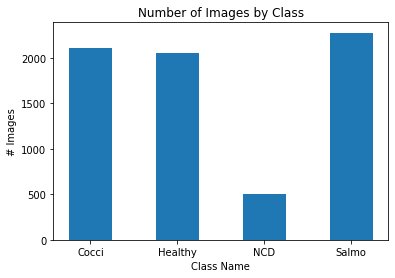

In [ ]:
dict_ = {"Cocci":len(cocci) ,"Healthy":len(healthy),"NCD": len(ncd),"Salmo":len(salmo)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

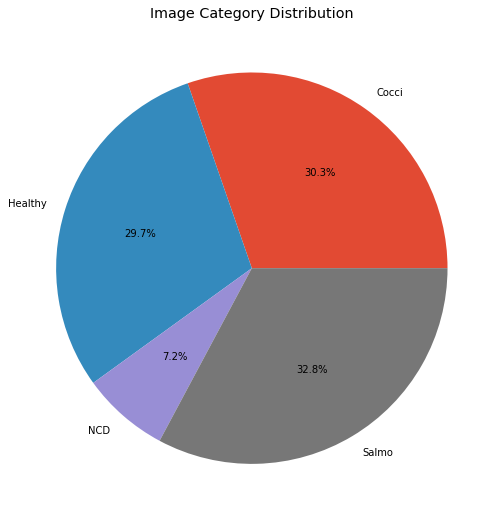

In [ ]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

**The Over-Sampling**

Augmentaion of images

In [ ]:
# we need to fix data imbalance (class NCD )
#Using Data Augmentation we can quickly increase the amount of data for our imbalanced classes,
#this will ensure that our model does not see the same image twice and helps avoid overfitting and aids the model to generalise better.
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

**CNN  Model**

In [ ]:
batch_size = 64
img_height = 299
img_width = 299
     

In [ ]:
data_dir = "/content/gdrive/MyDrive/data"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6937 files belonging to 4 classes.
Using 5550 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6937 files belonging to 4 classes.
Using 1387 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        1

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  batch_size = 64 
)

Epoch 1/100


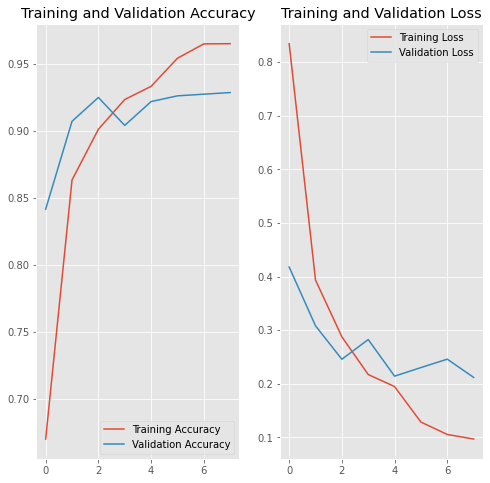

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()